In [1]:
%matplotlib inline
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import sys
import time

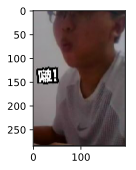

In [2]:
d2l.set_figsize()
img = image.imread('../img/hq.png')
d2l.plt.imshow(img.asnumpy())

In [3]:
# 本函数已保存在d2lzh包中方便以后使用
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes


In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    # aug图像增广方法
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

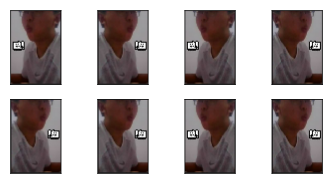

In [15]:
apply(img, gdata.vision.transforms.RandomFlipLeftRight())

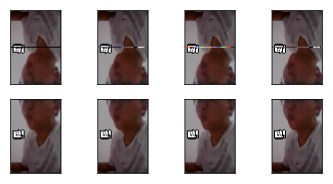

In [16]:
apply(img, gdata.vision.transforms.RandomFlipTopBottom())

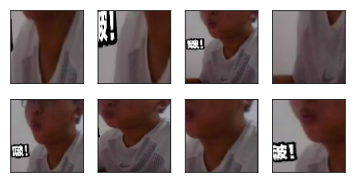

In [17]:
shape_aug = gdata.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

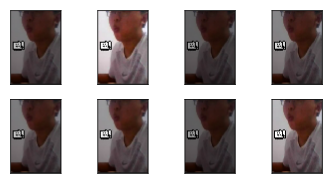

In [18]:
# 将图像的亮度随机变化为原图亮度的 50%
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

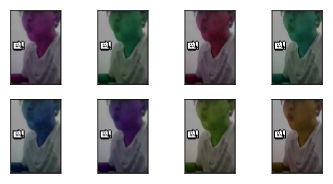

In [19]:
# 随机变化图像的色调
apply(img, gdata.vision.transforms.RandomHue(0.5))

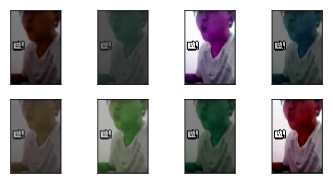

In [20]:
# 随机明亮度，对比度，饱和度，色调
color_aug = gdata.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

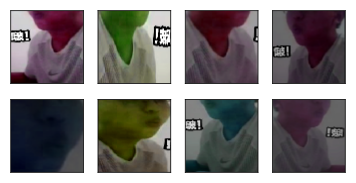

In [21]:
# 叠加了，左右变换，颜色变化，形状变换
augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

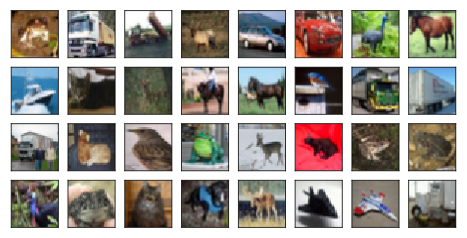

In [25]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=1);

In [5]:
# ToTensor实例将小批量图像转成MXNet需要的格式，
# 即形状为(批量大小, 通道数, 高, 宽)、值域在0到1之间且类型为32位浮点数
flip_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor()])

no_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.ToTensor()])

complex_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.RandomHue(0.5),
    gdata.vision.transforms.ToTensor()])

In [6]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size):
    # transform_first函数将图像增广应用在每个训练样本（图像和标签）的第一个元素，即图像之上。
    return gdata.DataLoader(
        gdata.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [7]:
def try_all_gpus():  # 本函数已保存在d2lzh包中方便以后使用
    ctxes = []
    try:
        for i in range(16):  # 假设一台机器上GPU的数量不超过16
            ctx = mx.gpu(i)
            _ = nd.array([0], ctx=ctx)
            ctxes.append(ctx)
    except mx.base.MXNetError:
        pass
    if not ctxes:
        ctxes = [mx.cpu()]
    return ctxes

In [8]:
# _get_batch将小批量数据样本batch划分并复制到ctx变量所指定的各个显存上。
def _get_batch(batch, ctx):
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

In [9]:
# 本函数已保存在d2lzh包中方便以后使用
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n = nd.array([0]), 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n

In [10]:
# 本函数已保存在d2lzh包中方便以后使用
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
                 time.time() - start))

In [11]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, ctx, net = 256, try_all_gpus(), d2l.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    loss = gloss.SoftmaxCrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=10)

In [ ]:
train_with_data_aug(flip_aug, no_aug)

In [14]:
train_with_data_aug(no_aug, no_aug)

training on [gpu(0)]


KeyboardInterrupt: 

In [12]:
train_with_data_aug(complex_aug, no_aug)

training on [gpu(0)]
epoch 1, loss 1.5822, train acc 0.446, test acc 0.496, time 69.3 sec
epoch 2, loss 0.9240, train acc 0.673, test acc 0.676, time 68.4 sec
epoch 3, loss 0.6791, train acc 0.764, test acc 0.739, time 68.6 sec
epoch 4, loss 0.5490, train acc 0.810, test acc 0.728, time 69.8 sec
epoch 5, loss 0.4555, train acc 0.842, test acc 0.777, time 70.5 sec
epoch 6, loss 0.3836, train acc 0.868, test acc 0.762, time 70.2 sec
epoch 7, loss 0.3227, train acc 0.889, test acc 0.795, time 69.8 sec
epoch 8, loss 0.2728, train acc 0.906, test acc 0.807, time 70.0 sec
epoch 9, loss 0.2392, train acc 0.918, test acc 0.823, time 70.8 sec
epoch 10, loss 0.1931, train acc 0.934, test acc 0.820, time 70.1 sec


In [16]:
import gc
gc.collect() # 清理内存

0